<a href="https://colab.research.google.com/github/ShodekeA/MyProjects/blob/main/Choosing_the_right_estimatorNEW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Machine Learning 
### Project: Model Selection

# Abstract

# Part 1: Business and Data Understanding

### Q. Define the problem domain

In [1]:
import pandas as pd
import numpy as np

#data = pd.read_csv('Agora.csv')
data = pd.read_csv('city-of-london-stop-and-search.csv')

In [ ]:
#Get more information about the data
data.info()


In [ ]:
#which columns can I delete?
data.describe()


In [ ]:
chosen_columns = data
chosen_columns.head()

In [5]:
#remove columns 3, 4, 5, 6 because they have lots of null values

chosen_columns = chosen_columns.drop(labels = ["Part of a policing operation", "Latitude", "Longitude", "Policing operation"], axis=1)


In [ ]:
chosen_columns.tail()

In [ ]:
for name in chosen_columns.columns:
  print(name , end="  ")
  print(data[name].value_counts())

In [ ]:
chosen_columns.info()

In [9]:
arrested = lambda d : 1 if d=='Arrest' else 0
outcome_linked = lambda d : 1 if d=='True' else 0

In [10]:
#Set 'Outcome' to True or False
chosen_columns['Outcome']  = chosen_columns['Outcome'].map(arrested)

In [ ]:
#Check that 'Outcome' is set to True or False
chosen_columns['Outcome'].value_counts()

In [12]:
#set 'Outcome linked to object of search'  True or False
chosen_columns['Outcome linked to object of search']  = chosen_columns['Outcome linked to object of search'].map(outcome_linked)

In [ ]:
#Check 'Outcome linked to object of search' is set to True or False
chosen_columns['Outcome linked to object of search'].value_counts()

In [14]:
#set 'Removal of more than just outer clothing'  True or False
chosen_columns['Removal of more than just outer clothing']  = chosen_columns['Removal of more than just outer clothing'].map(outcome_linked)

In [ ]:
#Check that 'Removal of more than just outer clothing' is set to True or False
chosen_columns['Removal of more than just outer clothing'].value_counts()

In [16]:
#Date is not required so i'll remove it
chosen_columns = chosen_columns.drop('Date', axis='columns')

In [ ]:
chosen_columns.info()

In [18]:
#pad null values
chosen_columns['Age range'] = chosen_columns['Age range'].fillna(False)
chosen_columns['Gender'] = chosen_columns['Gender'].fillna(False)
chosen_columns['Self-defined ethnicity'] = chosen_columns['Self-defined ethnicity'].fillna(False)
chosen_columns['Officer-defined ethnicity'] = chosen_columns['Officer-defined ethnicity'].fillna(False)
chosen_columns['Legislation'] = chosen_columns['Legislation'].fillna(False)
chosen_columns['Object of search'] = chosen_columns['Object of search'].fillna(False)

In [ ]:
chosen_columns['Age range'].value_counts()

In [ ]:
chosen_columns.head(1000)

In [21]:
#Add a new column 'Average age'
chosen_columns["Average age"] = chosen_columns["Age range"]

In [ ]:
#remove null values from 'Age average' column and outcome####

In [22]:
# Calculate average age
def cal_avg_age(age_range):
  avg_age = 0
  if age_range == "10-17":
    avg_age = (10 + 17)/2
  elif age_range == "18-24":
      avg_age = (18 + 24)/2
  elif age_range == "25-34":
     avg_age = (25 + 34)/2
  elif age_range == "over 34":
    avg_Age = 50
  else:
    avg_age = 0
  return avg_age

In [23]:
# Update the Average age
j = chosen_columns['Age range'].count()
temp2 = 0
for i in range(j):
  temp = chosen_columns['Age range'].values[i]
  temp2 = cal_avg_age(temp)
  chosen_columns['Average age'].values[i] = temp2
  


### Q. Identify candidate questions for your machine learning project

In [26]:
#Check relationship between average and Outcome of search
data_for_ml = chosen_columns.loc[:, ['Average age','Outcome']]
data_for_ml =  data_for_ml.loc[(data_for_ml["Average age"] > 0)]
#df = data_for_ml.groupby('Outcome')
#df.head()

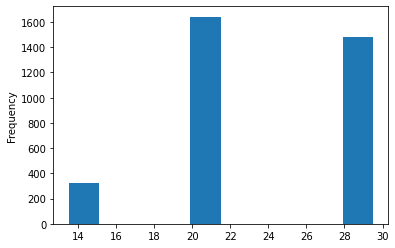

In [28]:
import matplotlib.pyplot as plt

data_for_ml['Average age'].plot(kind = 'hist')

plt.show()

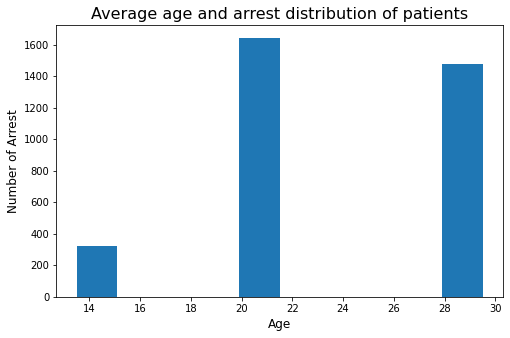

In [37]:
plt.figure(figsize=[8,5])
df = data_for_ml
plt.hist(data = df, x = "Average age")
plt.xlabel("Age", size = 12)
plt.ylabel("Number of Arrest", size = 12)
plt.title("Average age and arrest distribution of patients", size = 16);

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = data_for_ml
df.plot(kind = 'scatter', x = df['Average age'], y = df['Outcome'])

plt.show()


In [ ]:
data_for_ml['Average age'].value_counts()

In [ ]:
import itertools
p = d = q = range(0,2) # VALUE generators between [0,1] 
pdq = list(itertools.product(p,d,q)) # ALL possible combinations
print(pdq)
# below is the TRUTH table

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [ ]:
seasons = 2
seasonal_pdq = [  (x[0],x[1],x[2], seasons)   for x in pdq] 
seasonal_pdq

[(0, 0, 0, 2),
 (0, 0, 1, 2),
 (0, 1, 0, 2),
 (0, 1, 1, 2),
 (1, 0, 0, 2),
 (1, 0, 1, 2),
 (1, 1, 0, 2),
 (1, 1, 1, 2)]

In [ ]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df, model='additive')

# BEST possible values for P,D,Q and seasonal P,D,Q
# for lowest possible values of AIC 
best_score = 9999
best_pdq= (0,0,0)
best_spdq = (0,0,0)
for x1 in pdq:
  for x2 in seasonal_pdq:
    try:
      model = sm.tsa.statespace.SARIMAX(df, 
                                        order=x1, 
                                        seasonal_order=x2, 
                                        enforce_stationarity=False)
      # calculate the metric- AIC
      prediction = model.fit()
      # fitting-> training the model, scoring-> testing the model
      # compare predictions against the known results
      # it helps us calculate LOSS
      print(x1, end= " X ")
      print(x2, end=" = ")
      print(prediction.aic)

      if(prediction.aic < best_score):
        best_score = prediction.aic
        best_pdq = x1
        best_spdq = x2
      
    except Exception as ex:
      print(ex)
      continue

### Q. Identify a suitable dataset for your canditate question(s)

Go have a look at any of these websites:

* https://www.kaggle.com/datasets 
* https://datasetsearch.research.google.com/
* https://data.gov.uk/

Find an interesting looking data set related to your problem domain and get a copy of it


### Q. Generate a descriptive statistics report for the columns in your dataset

# Part 2: Data Preparation

### Q. Discuss the following types of missing data and how they would be handled in reference to your dataset where applicable.
*	Missing completely at random (MCAR)
*	Missing at random (MAR)
*	Missing Not at Random (MNAR)

# Part 3: Model Selection

### Q. Use the cheat sheet below to choose the algorithm/estimator suitable for building a model to address your candidate question(s)

* https://scikit-learn.org/stable/tutorial/machine_learning_map/

# Part 4: Model Evaluation

### Q. Identify which of the statistical measures below are suitable for the evaluation of your model.

Classification Metrics:
* Accuracy
* Precision
* Recall
* F1 Score

Regression Metrics:
    
* Mean absolute error (MAE)
* Root mean squared error (RMSE)
* Relative absolute error (RAE)
* Relative squared error (RSE)
* Mean Zero One Error (MZOE)
* Coefficient of determination

 

# Part 5: Stretch - Model Deployment

### Q. Evaluate the open-source app framework for Machine Learning model deployment below in your own time.

* https://streamlit.io/